In [1]:
import pandas as pd

In [2]:
ling = pd.read_csv('ling.csv')
ling

,subject,body,label
0,job posting - apple-iss research center,content - length : 3386 apple-iss research cen...,0
1,NaN,"lang classification grimes , joseph e . and ba...",0
2,query : letter frequencies for text identifica...,i am posting this inquiry for sergei atamas ( ...,0
3,risk,a colleague and i are researching the differin...,0
4,request book information,earlier this morning i was on the phone with a...,0
...,...,...,...
2854,win $ 300usd and a cruise !,"raquel 's casino , inc . is awarding a cruise ...",1
2855,you have been asked to join kiddin,"the list owner of : "" kiddin "" has invited you...",1
2856,anglicization of composers ' names,"judging from the return post , i must have sou...",0
2857,"re : 6 . 797 , comparative method : n - ary co...",gotcha ! there are two separate fallacies in t...,0


In [3]:
ling["label"].value_counts()

0    2401
1     458
Name: label, dtype: int64

In [4]:
ling["subject"]

0                 job posting - apple-iss research center
1                                                     NaN
2       query : letter frequencies for text identifica...
3                                                    risk
4                                request book information
                              ...                        
2854                          win $ 300usd and a cruise !
2855                   you have been asked to join kiddin
2856                   anglicization of composers ' names
2857    re : 6 . 797 , comparative method : n - ary co...
2858                 re : american - english in australia
Name: subject, Length: 2859, dtype: object

In [5]:
import sys

sys.path.append("../Handlers")

import preprocessing

[nltk_data] Downloading package punkt to E:/nltk...
[nltk_data]   Package punkt is already up-to-date!


In [6]:
subject = "subject"
body = "body"
ling_input = ling.apply(lambda x: f"{x[subject]} {x[body]}", axis=1)

In [7]:
from functools import partial

preprocession = partial(
    preprocessing.preprocess_text,
    remove_numbers=True,
)

preprocessed_data = ling_input.apply(preprocession)
preprocessed_data

0       [job, posting, appleiss, research, center, con...
1       [nan, lang, classification, grimes, joseph, e,...
2       [query, letter, frequencies, text, identificat...
3       [risk, colleague, researching, differing, degr...
4       [request, book, information, earlier, morning,...
                              ...                        
2854    [win, usd, cruise, raquel, casino, inc, awardi...
2855    [asked, join, kiddin, list, owner, kiddin, inv...
2856    [anglicization, composers, names, judging, ret...
2857    [comparative, method, n, ary, comparison, gotc...
2858    [american, english, australia, hello, working,...
Length: 2859, dtype: object

In [8]:
import itertools

combined = list(itertools.chain.from_iterable(preprocessed_data))
len(combined)

778913

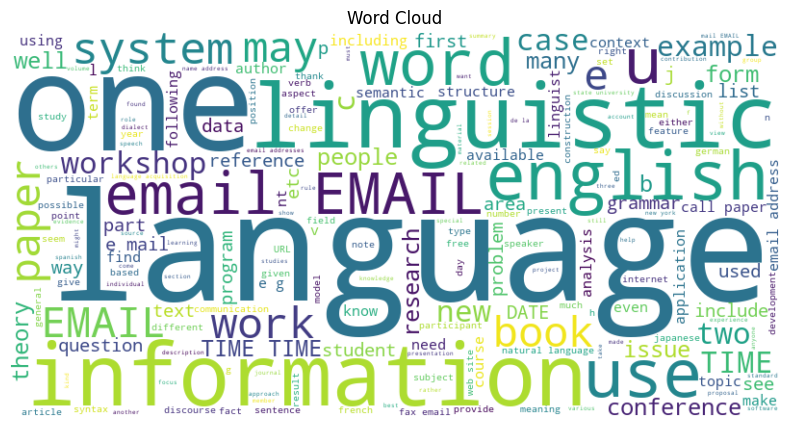

In [9]:
preprocessing.visualize_wordcloud(combined)

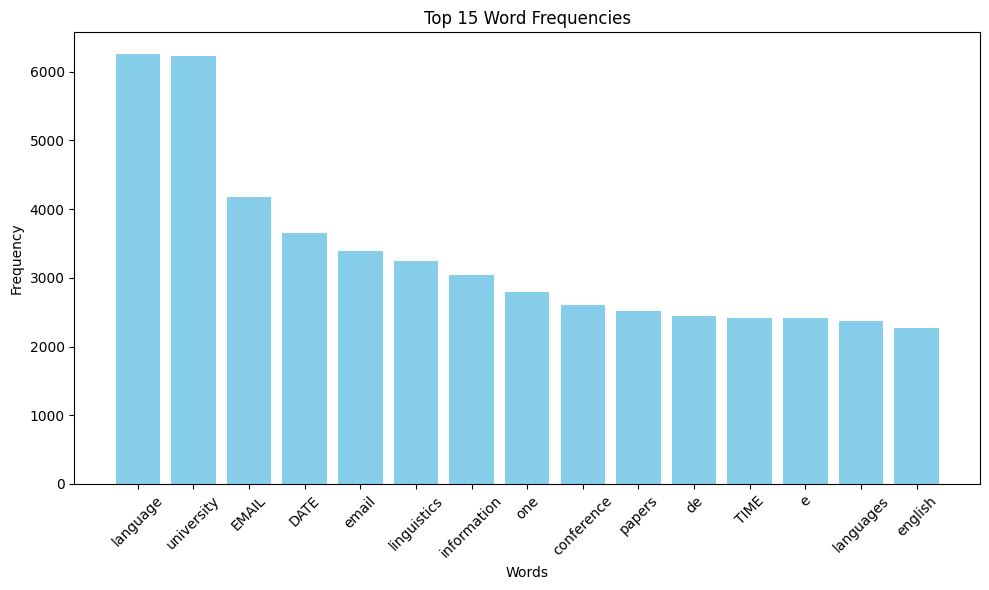

In [10]:
from collections import Counter
import matplotlib.pyplot as plt

counter = Counter(combined)
most_common = counter.most_common(15)

words, counts = zip(*most_common)

plt.figure(figsize=(10, 6))
plt.bar(words, counts, color='skyblue')
plt.title("Top 15 Word Frequencies")
plt.xlabel("Words")
plt.ylabel("Frequency")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

del combined

In [ ]:
from traintest import ClassificationModel, models, add_to_json_array
from concurrent.futures import ThreadPoolExecutor
from functools import partial

metric_results = []

def t_and_e(model, X, y, dataset_name):
    classification_model = ClassificationModel(model, dataset_name)
    classification_model.train(X, y, save_model=True)
    print(f"{model.__class__.__name__} classification report")
    metrics = classification_model.evaluate(detailed=True)
    metric_results.append(metrics)
    print(metrics)
    print("\n")

def train_and_evaluate_model(X, y, dataset_name, m=None):
    print(f"{dataset_name} classification report")
    print("=========================================")

    train_eval = partial(
        t_and_e,
        X=X,
        y=y,
        dataset_name=dataset_name,
    )

    if m is None:
        with ThreadPoolExecutor(max_workers=3) as executor:
            executor.map(train_eval, models)
    else:
        train_eval(m)

## Stemming + CountVectorizer

In [12]:
ling_stemming = preprocessed_data.apply(preprocessing.stemming)

In [13]:
ling_stemming_countvec = preprocessing.vectorizing(ling_stemming, "countvectorizer")

In [14]:
train_and_evaluate_model(ling_stemming_countvec, ling["label"], "ling_stemmed_countvec")
del ling_stemming_countvec

ling_stemmed_countvec classification report
SVC classification report
{'dataset': 'ling_stemmed_countvec', 'model': 'SVM', 'type': 'normal', 'metrics': {'accuracy': 0.9667832167832168, 'weighted_precision': 0.9680086903387874, 'wighted_recall': 0.9667832167832168, 'weighted_f1': 0.9647227154645551, 'macro_precision': 0.9815533980582525, 'macro_recall': 0.875, 'macro_f1': 0.9191747915783524, 'roc_auc': 0.875}, 'confusion_matrix': array([[496,   0],
       [ 19,  57]], dtype=int64)}


MultinomialNB classification report
{'dataset': 'ling_stemmed_countvec', 'model': 'Multinomial Naive Bayes', 'type': 'normal', 'metrics': {'accuracy': 0.993006993006993, 'weighted_precision': 0.993134395968404, 'wighted_recall': 0.993006993006993, 'weighted_f1': 0.993045338499884, 'macro_precision': 0.979757085020243, 'macro_recall': 0.9903968590831917, 'macro_f1': 0.984992784992785, 'roc_auc': 0.9903968590831919}, 'confusion_matrix': array([[493,   3],
       [  1,  75]], dtype=int64)}


BernoulliNB classi

TypeError: A sparse matrix was passed, but dense data is required. Use X.toarray() to convert to a dense numpy array.

## Stemming + TF-IDF

SVC ling classification report
              precision    recall  f1-score   support

           0       0.99      1.00      1.00       496
           1       1.00      0.96      0.98        76

    accuracy                           0.99       572
   macro avg       1.00      0.98      0.99       572
weighted avg       0.99      0.99      0.99       572



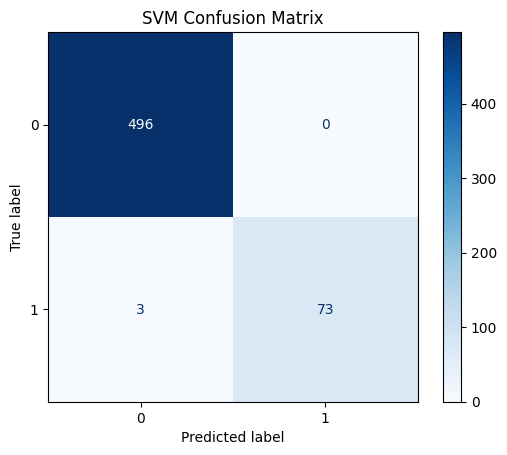



SVC ling classification report
              precision    recall  f1-score   support

           0       0.99      1.00      0.99       496
           1       1.00      0.92      0.96        76

    accuracy                           0.99       572
   macro avg       0.99      0.96      0.98       572
weighted avg       0.99      0.99      0.99       572



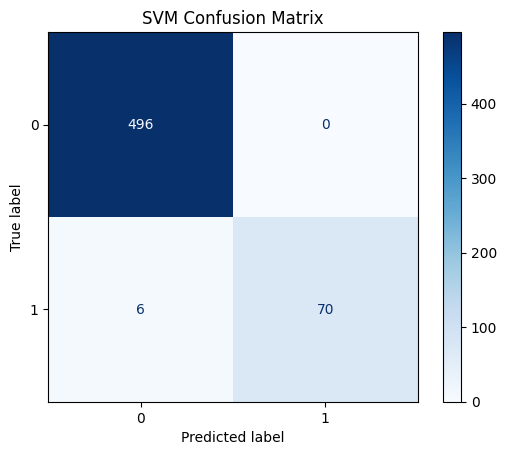



MultinomialNB ling classification report
              precision    recall  f1-score   support

           0       0.98      1.00      0.99       496
           1       1.00      0.87      0.93        76

    accuracy                           0.98       572
   macro avg       0.99      0.93      0.96       572
weighted avg       0.98      0.98      0.98       572



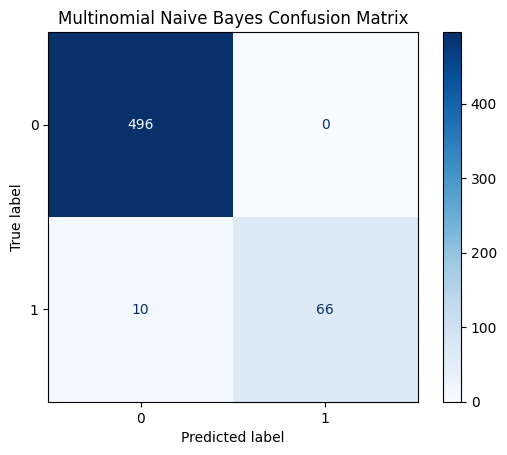



BernoulliNB ling classification report
              precision    recall  f1-score   support

           0       0.99      1.00      0.99       496
           1       1.00      0.92      0.96        76

    accuracy                           0.99       572
   macro avg       0.99      0.96      0.98       572
weighted avg       0.99      0.99      0.99       572



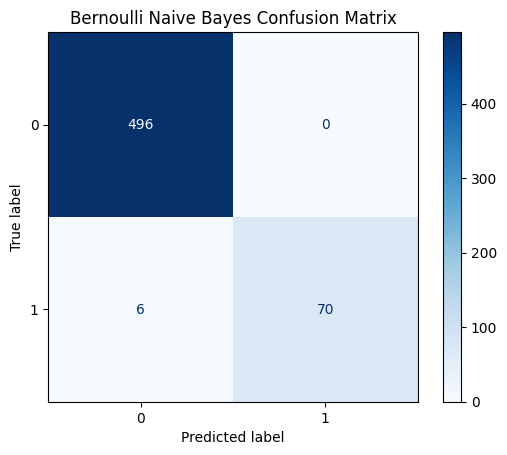



RandomForestClassifier ling classification report
              precision    recall  f1-score   support

           0       0.98      1.00      0.99       496
           1       1.00      0.87      0.93        76

    accuracy                           0.98       572
   macro avg       0.99      0.93      0.96       572
weighted avg       0.98      0.98      0.98       572



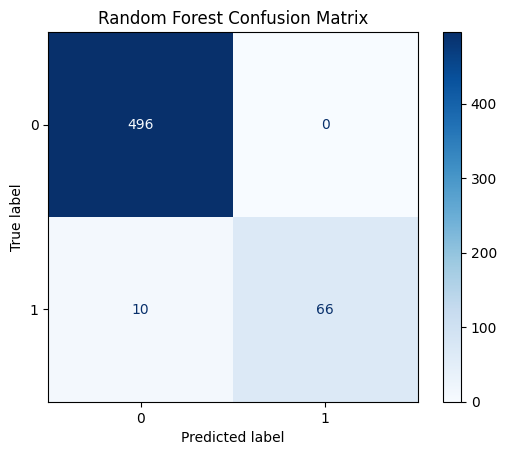



DecisionTreeClassifier ling classification report
              precision    recall  f1-score   support

           0       0.97      0.98      0.97       496
           1       0.86      0.80      0.83        76

    accuracy                           0.96       572
   macro avg       0.91      0.89      0.90       572
weighted avg       0.96      0.96      0.96       572



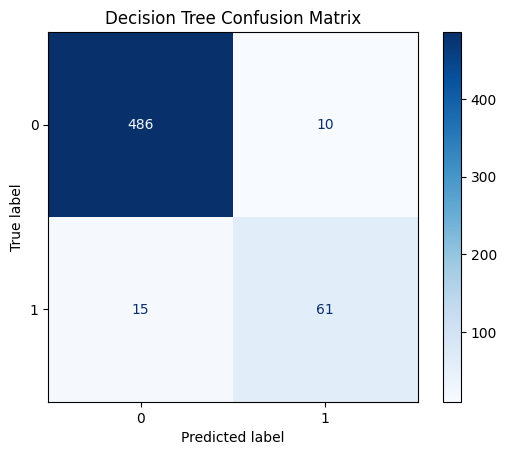



AdaBoostClassifier ling classification report
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       496
           1       0.96      0.92      0.94        76

    accuracy                           0.98       572
   macro avg       0.97      0.96      0.97       572
weighted avg       0.98      0.98      0.98       572



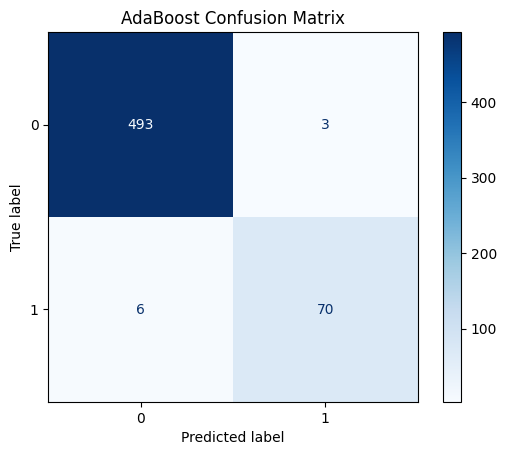



LogisticRegression ling classification report
              precision    recall  f1-score   support

           0       0.98      1.00      0.99       496
           1       1.00      0.84      0.91        76

    accuracy                           0.98       572
   macro avg       0.99      0.92      0.95       572
weighted avg       0.98      0.98      0.98       572



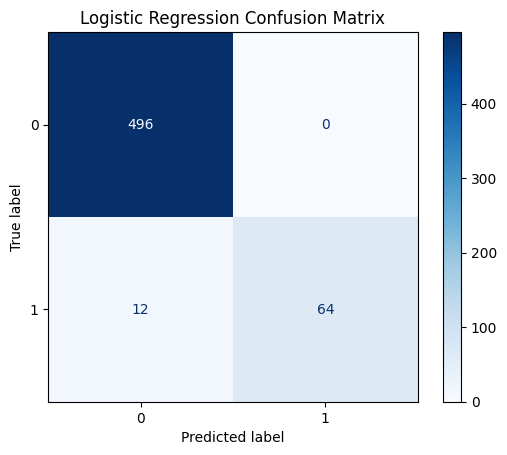



KNeighborsClassifier ling classification report
              precision    recall  f1-score   support

           0       1.00      0.99      0.99       496
           1       0.94      0.99      0.96        76

    accuracy                           0.99       572
   macro avg       0.97      0.99      0.98       572
weighted avg       0.99      0.99      0.99       572



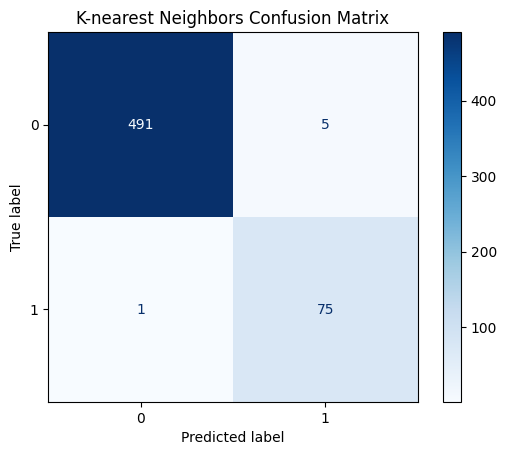

In [ ]:
ling_stemming_tfidf = preprocessing.vectorizing(ling_stemming, "tfidf")

train_and_evaluate_model(ling_stemming_tfidf, ling["label"], "ling_stemmed_tfidf")
del ling_stemming_tfidf
del ling_stemming

## Lemmatizing + CountVectorizer

In [ ]:
ling_lemmatizing = preprocessed_data.apply(preprocessing.lemmatizing)

SVC ling classification report
              precision    recall  f1-score   support

           0       0.99      1.00      1.00       496
           1       0.99      0.96      0.97        76

    accuracy                           0.99       572
   macro avg       0.99      0.98      0.98       572
weighted avg       0.99      0.99      0.99       572



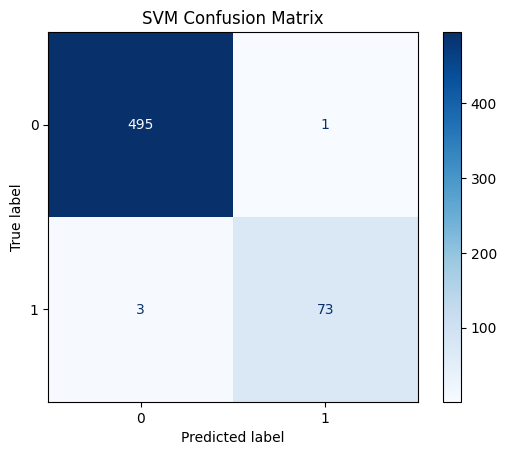



SVC ling classification report
              precision    recall  f1-score   support

           0       0.96      1.00      0.98       496
           1       1.00      0.74      0.85        76

    accuracy                           0.97       572
   macro avg       0.98      0.87      0.91       572
weighted avg       0.97      0.97      0.96       572



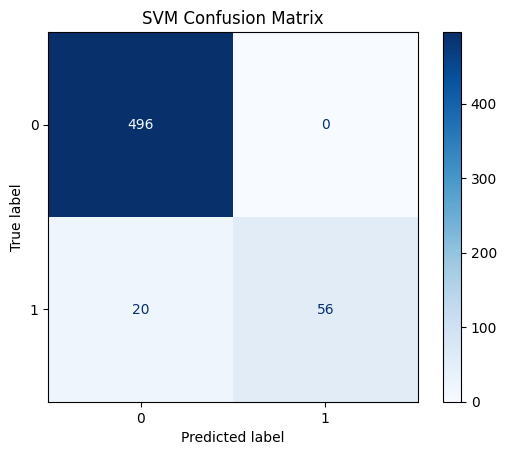



MultinomialNB ling classification report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       496
           1       0.97      0.99      0.98        76

    accuracy                           0.99       572
   macro avg       0.99      0.99      0.99       572
weighted avg       0.99      0.99      0.99       572



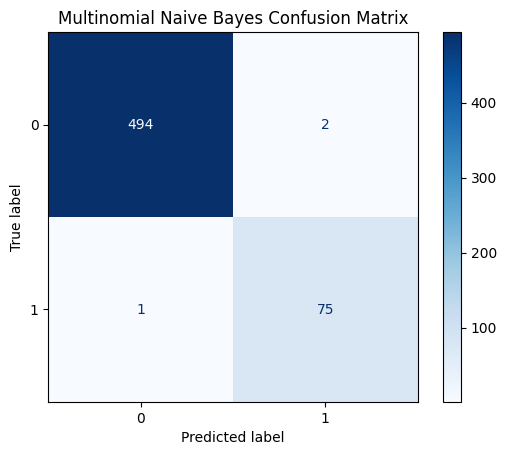



BernoulliNB ling classification report
              precision    recall  f1-score   support

           0       0.98      1.00      0.99       496
           1       1.00      0.88      0.94        76

    accuracy                           0.98       572
   macro avg       0.99      0.94      0.96       572
weighted avg       0.98      0.98      0.98       572



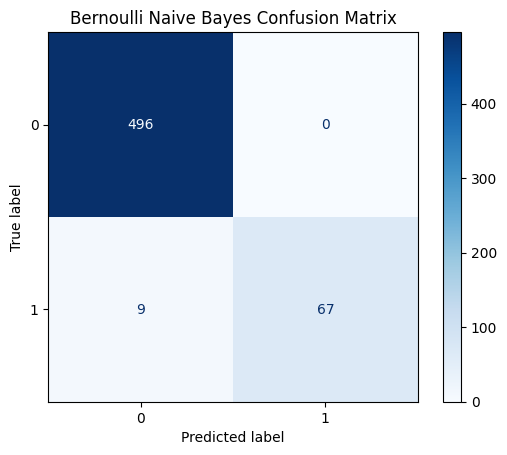



RandomForestClassifier ling classification report
              precision    recall  f1-score   support

           0       0.98      1.00      0.99       496
           1       1.00      0.89      0.94        76

    accuracy                           0.99       572
   macro avg       0.99      0.95      0.97       572
weighted avg       0.99      0.99      0.99       572



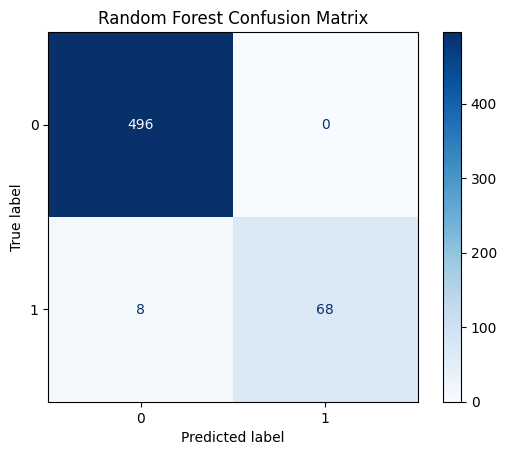



DecisionTreeClassifier ling classification report
              precision    recall  f1-score   support

           0       0.98      0.97      0.97       496
           1       0.80      0.87      0.84        76

    accuracy                           0.95       572
   macro avg       0.89      0.92      0.90       572
weighted avg       0.96      0.95      0.96       572



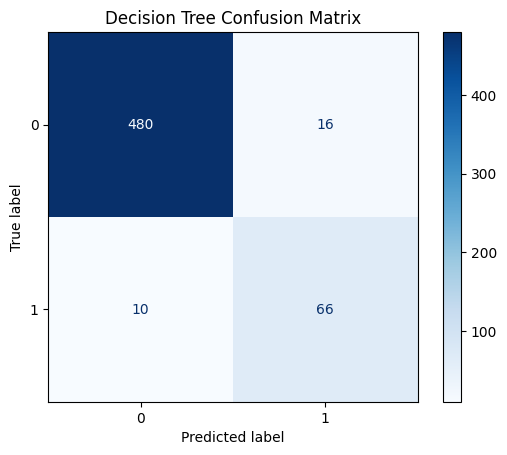



AdaBoostClassifier ling classification report
              precision    recall  f1-score   support

           0       0.99      1.00      0.99       496
           1       1.00      0.92      0.96        76

    accuracy                           0.99       572
   macro avg       0.99      0.96      0.98       572
weighted avg       0.99      0.99      0.99       572



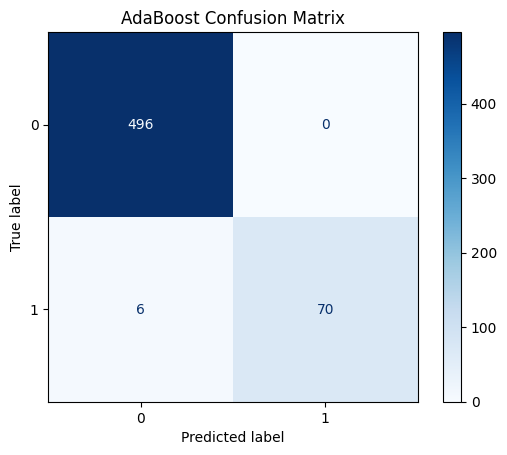



LogisticRegression ling classification report
              precision    recall  f1-score   support

           0       0.99      1.00      1.00       496
           1       1.00      0.96      0.98        76

    accuracy                           0.99       572
   macro avg       1.00      0.98      0.99       572
weighted avg       0.99      0.99      0.99       572



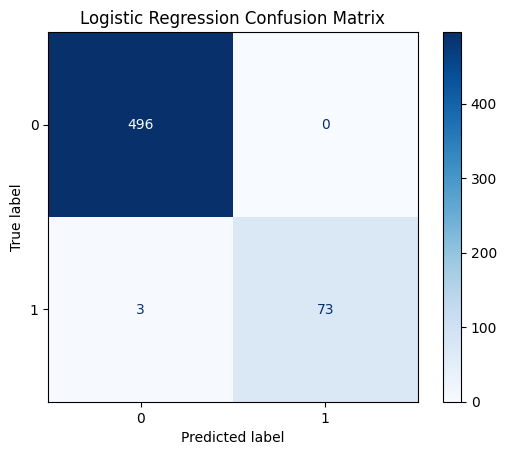



KNeighborsClassifier ling classification report
              precision    recall  f1-score   support

           0       0.97      0.93      0.95       496
           1       0.65      0.84      0.74        76

    accuracy                           0.92       572
   macro avg       0.81      0.89      0.84       572
weighted avg       0.93      0.92      0.92       572



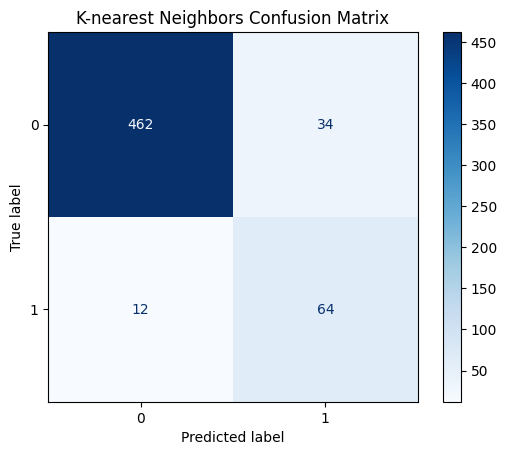

In [ ]:
ling_lemmatizing_countvec = preprocessing.vectorizing(ling_lemmatizing, "countvectorizer")

train_and_evaluate_model(ling_lemmatizing_countvec, ling["label"], "ling_lemmatized_countvec")
del ling_lemmatizing_countvec

## Lemmatizing + TF-IDF

SVC ling classification report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       496
           1       1.00      0.97      0.99        76

    accuracy                           1.00       572
   macro avg       1.00      0.99      0.99       572
weighted avg       1.00      1.00      1.00       572



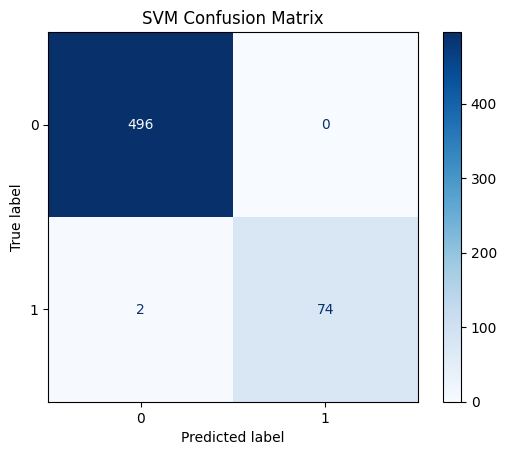



SVC ling classification report
              precision    recall  f1-score   support

           0       0.98      1.00      0.99       496
           1       1.00      0.89      0.94        76

    accuracy                           0.99       572
   macro avg       0.99      0.95      0.97       572
weighted avg       0.99      0.99      0.99       572



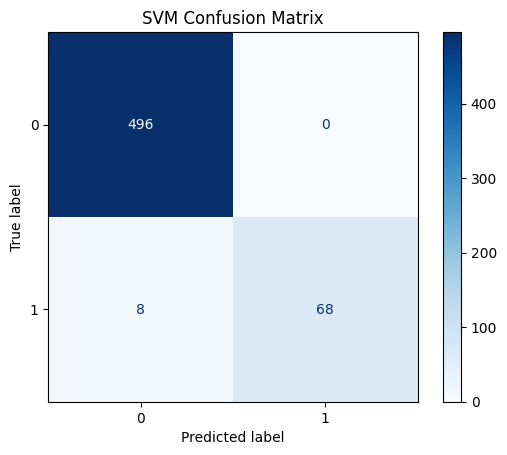



MultinomialNB ling classification report
              precision    recall  f1-score   support

           0       0.99      1.00      0.99       496
           1       1.00      0.91      0.95        76

    accuracy                           0.99       572
   macro avg       0.99      0.95      0.97       572
weighted avg       0.99      0.99      0.99       572



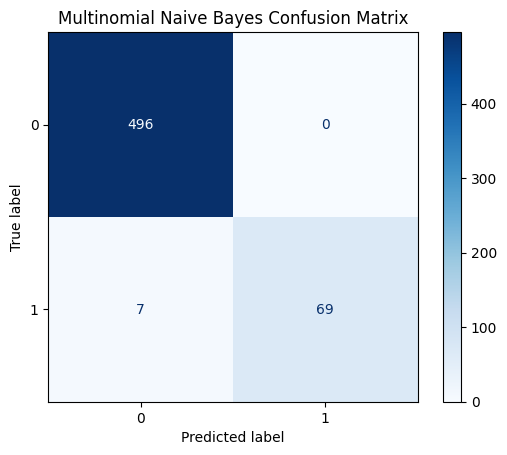



BernoulliNB ling classification report
              precision    recall  f1-score   support

           0       0.98      1.00      0.99       496
           1       1.00      0.88      0.94        76

    accuracy                           0.98       572
   macro avg       0.99      0.94      0.96       572
weighted avg       0.98      0.98      0.98       572



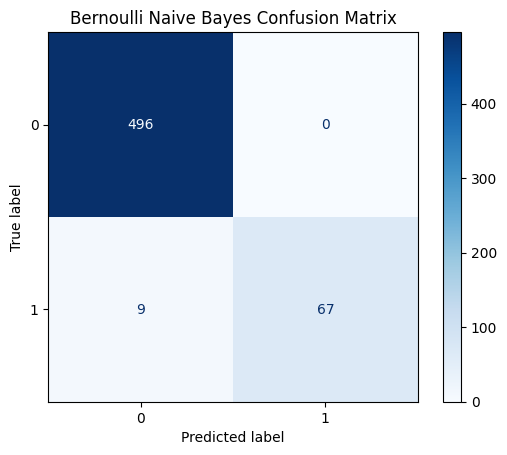



RandomForestClassifier ling classification report
              precision    recall  f1-score   support

           0       0.98      1.00      0.99       496
           1       1.00      0.89      0.94        76

    accuracy                           0.99       572
   macro avg       0.99      0.95      0.97       572
weighted avg       0.99      0.99      0.99       572



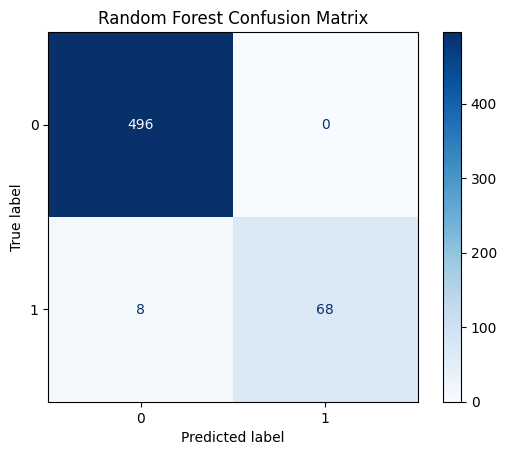



DecisionTreeClassifier ling classification report
              precision    recall  f1-score   support

           0       0.97      0.99      0.98       496
           1       0.91      0.83      0.87        76

    accuracy                           0.97       572
   macro avg       0.94      0.91      0.92       572
weighted avg       0.97      0.97      0.97       572



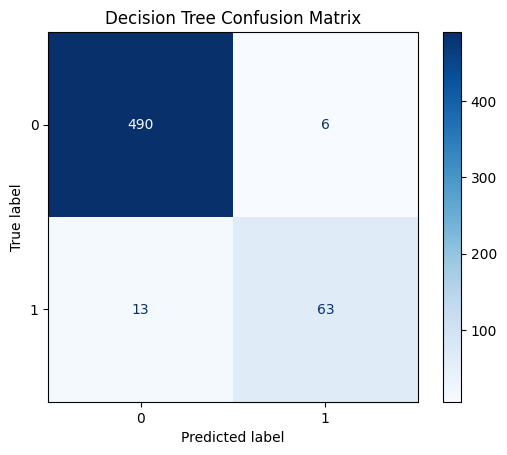



AdaBoostClassifier ling classification report
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       496
           1       0.96      0.95      0.95        76

    accuracy                           0.99       572
   macro avg       0.98      0.97      0.97       572
weighted avg       0.99      0.99      0.99       572



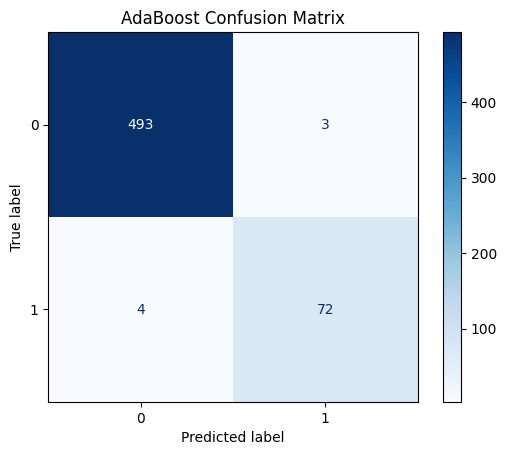



LogisticRegression ling classification report
              precision    recall  f1-score   support

           0       0.98      1.00      0.99       496
           1       1.00      0.86      0.92        76

    accuracy                           0.98       572
   macro avg       0.99      0.93      0.96       572
weighted avg       0.98      0.98      0.98       572



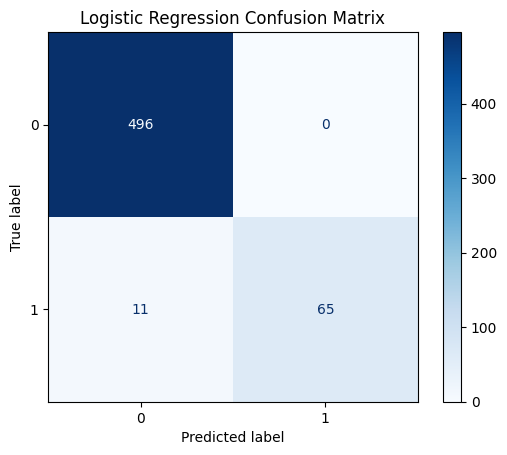



KNeighborsClassifier ling classification report
              precision    recall  f1-score   support

           0       1.00      0.99      0.99       496
           1       0.95      0.99      0.97        76

    accuracy                           0.99       572
   macro avg       0.97      0.99      0.98       572
weighted avg       0.99      0.99      0.99       572



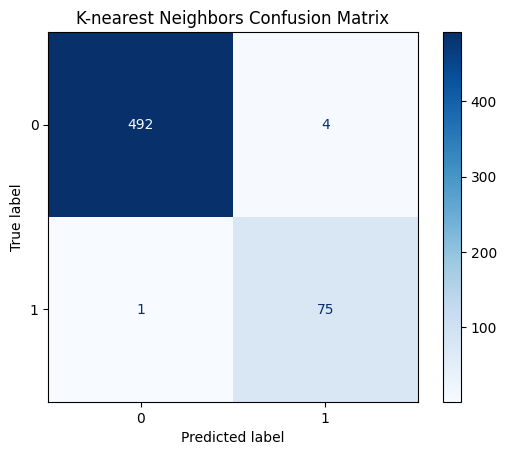

In [ ]:
ling_lemmatizing_tfidf = preprocessing.vectorizing(ling_lemmatizing, "tfidf")

train_and_evaluate_model(ling_lemmatizing_tfidf, ling["label"], "ling_lemmatized_tfidf")

del ling_lemmatizing_tfidf
del ling_lemmatizing

In [ ]:
def convert(dic):
    dic["confusion_matrix"] = dic["confusion_matrix"].tolist()
    return dic

metric_results = list(map(convert, metric_results))

add_to_json_array("./ling_classification_report.json", metric_results, mode="overwrite")